In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
# import statsmodels.api as sm
from scipy import stats
import os
import math
from sklearn import metrics
from autogluon.tabular import TabularDataset,TabularPredictor

In [ ]:
!pip install autogluon

In [ ]:
# display all features
pd.set_option('display.max_columns', None)

In [ ]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test-full.csv")
df_result = pd.read_csv("full_submission.csv")

In [ ]:
Y_train = df_train.iloc[:,-1]

In [ ]:
df_answer = pd.read_csv("result_answer.csv")

In [ ]:
# modify the soil
def soil(rs_df):
    rs_df["new_Soil_Type_1"] = rs_df["Soil_Type1"]+rs_df["Soil_Type2"]+rs_df["Soil_Type3"]+rs_df["Soil_Type4"]+rs_df["Soil_Type5"]+rs_df["Soil_Type6"]
    rs_df["new_Soil_Type_2"] = rs_df["Soil_Type7"]+rs_df["Soil_Type8"]
    rs_df["new_Soil_Type_3"] = rs_df["Soil_Type9"]
    rs_df["new_Soil_Type_4"] = rs_df["Soil_Type10"]+rs_df["Soil_Type11"]+rs_df["Soil_Type12"]+rs_df["Soil_Type13"]
    rs_df["new_Soil_Type_5"] = rs_df["Soil_Type14"]+rs_df["Soil_Type15"]
    rs_df["new_Soil_Type_6"] = rs_df["Soil_Type16"]+rs_df["Soil_Type17"]
    rs_df["new_Soil_Type_7"] = rs_df["Soil_Type18"]
    rs_df["new_Soil_Type_8"] = rs_df["Soil_Type19"]+rs_df["Soil_Type20"]+rs_df["Soil_Type21"]
    rs_df["new_Soil_Type_9"] = rs_df["Soil_Type22"]+rs_df["Soil_Type23"]
    rs_df["new_Soil_Type_10"] = rs_df["Soil_Type24"]+rs_df["Soil_Type25"]+rs_df["Soil_Type26"]+rs_df["Soil_Type27"]+rs_df["Soil_Type28"]+rs_df["Soil_Type29"] \
                               +rs_df["Soil_Type30"]+rs_df["Soil_Type31"]+rs_df["Soil_Type32"]+rs_df["Soil_Type33"]+rs_df["Soil_Type34"]
    rs_df["new_Soil_Type_11"] = rs_df["Soil_Type35"]+rs_df["Soil_Type36"]+rs_df["Soil_Type37"]+rs_df["Soil_Type38"]+rs_df["Soil_Type39"]+rs_df["Soil_Type40"]

    rs_df['Soil1'] = 0
    # rs_df['Soil2'] = 0
    for i in range(1,41):
        rs_df['Soil1']= rs_df['Soil1'] + i * rs_df['Soil_Type'+str(i)]
        rs_df = rs_df.drop("Soil_Type"+str(i),axis=1)       
    for i in range(1,12):
        # rs_df['Soil2']= rs_df['Soil2'] + i * rs_df['new_Soil_Type_'+str(i)]
        rs_df = rs_df.drop("new_Soil_Type_"+str(i),axis=1)
    
    return rs_df

In [ ]:
df_train = soil(df_train)
df_test = soil(df_test)

In [ ]:
def Aspect_r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

In [ ]:
def feature_engineering(df_train):
    rs_df = df_train
    rs_df['Id2'] = (14*rs_df['Id']/581012).astype(int)
    rs_df['Id3'] = (120*rs_df['Id']/581012).astype(int)
    rs_df['Id4'] = (1200*rs_df['Id']/581012).astype(int)
    rs_df['Id5'] = (12000*rs_df['Id']/581012).astype(int)
    rs_df['Id5'] = (120000*rs_df['Id']/581012).astype(int)
    rs_df['Dist_to_Hydrology'] = (rs_df['Horizontal_Distance_To_Hydrology']**2 + rs_df['Vertical_Distance_To_Hydrology']**2)**0.5
    rs_df['slope_hyd_pct1'] = rs_df['Vertical_Distance_To_Hydrology']/(rs_df['Horizontal_Distance_To_Hydrology']+0.00001)
    rs_df['slope_hyd_pct2'] = rs_df['Horizontal_Distance_To_Hydrology']/(rs_df['Vertical_Distance_To_Hydrology']+0.00001)
    rs_df['Aspect2'] = rs_df['Aspect'].map(Aspect_r)
    rs_df['Cos_slope'] = np.cos(rs_df['Slope']*2*np.pi/360)
    rs_df['Elev_m_VDH'] = rs_df['Elevation'] - rs_df['Vertical_Distance_To_Hydrology']
    rs_df['Elev_m_HDH'] = rs_df['Elevation'] - rs_df['Horizontal_Distance_To_Hydrology']*0.28
    # rs_df['level_Elev'] = [math.floor(v/20) for v in df_train['Elevation']]
    # rs_df['HighWater'] = np.sign(rs_df['Vertical_Distance_To_Hydrology'])
    rs_df['Mean_Hydro'] = (rs_df['Horizontal_Distance_To_Hydrology']+rs_df['Horizontal_Distance_To_Fire_Points']+rs_df['Horizontal_Distance_To_Roadways'])/3
    
    # rs_df['Mean_Hydro2'] = np.sqrt(((rs_df['Horizontal_Distance_To_Hydrology']**2+rs_df['Horizontal_Distance_To_Fire_Points']**2+rs_df['Horizontal_Distance_To_Roadways']**2)/3))
    rs_df['Hydro_p_Fire'] = rs_df['Horizontal_Distance_To_Hydrology'] + rs_df['Horizontal_Distance_To_Fire_Points']
    rs_df['Hydro_m_Fire'] = rs_df['Horizontal_Distance_To_Hydrology'] - rs_df['Horizontal_Distance_To_Fire_Points']
    rs_df['Hydro_p_Road'] = rs_df['Horizontal_Distance_To_Hydrology'] + rs_df['Horizontal_Distance_To_Roadways']
    rs_df['Hydro_p_Road'] = rs_df['Horizontal_Distance_To_Hydrology'] - rs_df['Horizontal_Distance_To_Roadways']
    rs_df['Fire_p_Road'] = rs_df['Horizontal_Distance_To_Fire_Points'] + rs_df['Horizontal_Distance_To_Roadways']
    rs_df['Fire_m_Road'] = rs_df['Horizontal_Distance_To_Fire_Points'] - rs_df['Horizontal_Distance_To_Roadways']
    
    rs_df['sq_interaction_9amnoon'] = np.sqrt(rs_df['Hillshade_9am']*rs_df['Hillshade_Noon'])
    rs_df['sq_interaction_noon3pm'] = np.sqrt(rs_df['Hillshade_Noon']*rs_df['Hillshade_3pm'])
    rs_df['sq_interaction_9am3pm'] = np.sqrt(rs_df['Hillshade_9am']*rs_df['Hillshade_3pm'])
    rs_df['Mean_Hillshade'] = (rs_df['Hillshade_9am']+rs_df['Hillshade_Noon']+rs_df['Hillshade_3pm'])/3
    
    
    rs_df['Wilderness_Area'] = 0
    for i in range(1,5):
        rs_df['Wilderness_Area'] = rs_df['Wilderness_Area'] + i * rs_df['Wilderness_Area'+str(i)]
        rs_df = rs_df.drop("Wilderness_Area"+str(i),axis=1)
    rs_df['Wilderness_Area'] = rs_df['Wilderness_Area']**3
    
    return rs_df

In [ ]:
df_train = feature_engineering(df_train)
df_test = feature_engineering(df_test)

In [ ]:
def plotc(c1,c2):

    fig = plt.figure(figsize=(10,6))
    sel = np.array(list(Y_train.values))
    
    plt.title("Relation of new feature and Vertical Hydrology")
    plt.scatter(c1, c2, c=sel, s=40,cmap='rainbow')
    plt.xlabel(c1.name)
    plt.ylabel(c2.name)
    
# plotc(df_train['Elev_m_VDH'], df_train['Vertical_Distance_To_Hydrology'])

In [ ]:
X_train = df_train
X_test = df_test
X_train = X_train.drop('Cover_Type',axis=1)

In [ ]:
X_train

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil1,Id2,Id3,Id4,Id5,Dist_to_Hydrology,slope_hyd_pct1,slope_hyd_pct2,Aspect2,Cos_slope,Elev_m_VDH,Elev_m_HDH,Mean_Hydro,Hydro_p_Fire,Hydro_m_Fire,Hydro_p_Road,Fire_p_Road,Fire_m_Road,sq_interaction_9amnoon,sq_interaction_noon3pm,sq_interaction_9am3pm,Mean_Hillshade,Wilderness_Area
0,242642,2881,130,22,210,54,1020,250,221,88,342,30,5,50,501,50114,216.831732,0.257143,3.888888,310,0.927184,2827,2822.20,524.000000,552,-132,-810,1362,-678,235.053185,139.456086,148.323970,186.333333,1
1,309891,3005,351,14,242,-16,1371,194,215,159,842,24,7,64,640,64003,242.528349,-0.066116,-15.125009,171,0.970296,3021,2937.24,818.333333,1084,-600,-1129,2213,-529,204.230262,184.891860,175.630294,189.333333,27
2,287847,3226,63,14,618,2,1092,232,210,107,2018,29,6,59,594,59450,618.003236,0.003236,308.998455,243,0.970296,3224,3052.96,1242.666667,2636,-1400,-474,3110,926,220.726075,149.899967,157.556339,183.000000,1
3,516307,3298,317,8,661,60,752,198,233,174,1248,23,12,106,1066,106636,663.717560,0.090772,11.016665,137,0.990268,3238,3112.92,887.000000,1909,-587,-91,2000,496,214.788268,201.350441,185.612500,201.666667,8
4,124860,3080,35,6,175,26,3705,219,227,144,2673,24,3,25,257,25788,176.920886,0.148571,6.730767,215,0.994522,3054,3031.00,2184.333333,2848,-2498,-3530,6378,-1032,222.964123,180.798230,177.583783,196.666667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,475155,3328,321,13,323,12,5109,186,227,180,3151,38,11,98,981,98136,323.222833,0.037152,26.916644,141,0.974370,3316,3237.56,2861.000000,3474,-2828,-4786,8260,-1958,205.479926,202.138566,182.975408,197.666667,27
15116,514378,3455,37,5,841,92,939,220,229,146,362,40,12,106,1062,106237,846.017139,0.109394,9.141303,217,0.996195,3363,3219.52,714.000000,1203,479,-98,1301,-577,224.454895,182.849665,179.220535,198.333333,8
15117,368425,3279,90,14,404,113,1513,240,218,105,1503,29,8,76,760,76093,419.505661,0.279703,3.575221,270,0.970296,3166,3165.88,1140.000000,1907,-1099,-1109,3016,-10,228.735655,151.294415,158.745079,187.666667,1
15118,537844,3589,357,9,418,52,1868,205,223,155,1657,40,12,111,1110,111084,421.222032,0.124402,8.038460,177,0.987688,3537,3471.96,1314.333333,2075,-1239,-1450,3525,-211,213.810664,185.916648,178.255435,194.333333,8


______________________________

In [ ]:
# Removing features with low variance
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit_transform(X_train).shape

(15120, 34)

In [ ]:
# X_train = X_train.drop('Soil_Type15',axis=1)
# X_test = X_test.drop('Soil_Type15',axis=1)

Index(['Id', 'Elevation', 'Horizontal_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am',
       'Horizontal_Distance_To_Fire_Points', 'Soil1', 'Id2', 'Id3', 'Id4',
       'Id5', 'Elev_m_VDH', 'Elev_m_HDH', 'Mean_Hydro', 'Hydro_p_Fire',
       'Hydro_m_Fire', 'Hydro_p_Road', 'Fire_p_Road', 'sq_interaction_9amnoon',
       'Wilderness_Area'],
      dtype='object')

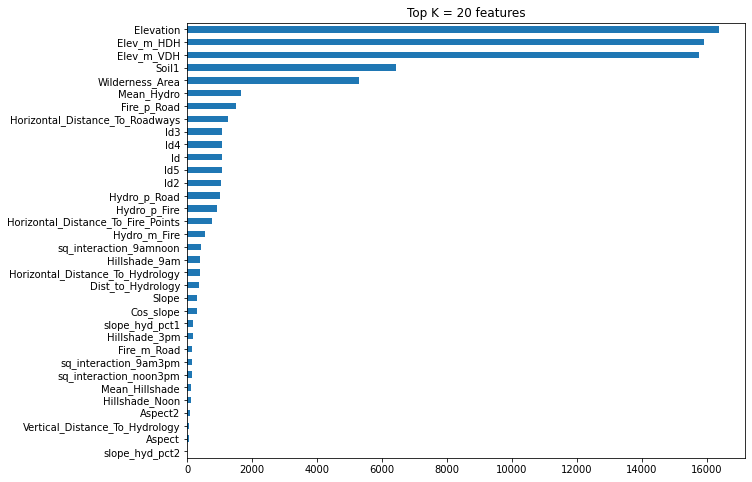

In [ ]:
from sklearn.feature_selection import SelectKBest,f_classif
F,pval = f_classif(X_train,Y_train)
# print(F,pval)

Fvalues_fclassif = pd.Series(F,index = X_train.columns)
plt.figure(figsize=(10, 8))
plt.title("Top K = 20 features")
Fvalues_fclassif.sort_values(inplace = True)
Fvalues_fclassif.plot.barh()

selector = SelectKBest(f_classif, k=20)
selector.fit_transform(X_train, Y_train)
X_train.columns[selector.get_support()]

In [ ]:
X_train = X_train[X_train.columns[selector.get_support()]]
X_test = X_test[X_test.columns[selector.get_support()]]

In [ ]:
y = df_train["Cover_Type"]

In [ ]:
X_train.insert(X_train.shape[1], 'Cover_type', y)

_____________________________

In [ ]:
predictor=TabularPredictor(label="Cover_type").fit(X_train,presets='best_quality')

No path specified. Models will be saved in: "AutogluonModels/ag-20220105_165815/"
Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220105_165815/"
AutoGluon Version:  0.3.1
Train Data Rows:    15120
Train Data Columns: 20
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	7 unique label values:  [1, 2, 3, 4, 5, 6, 7]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 7
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11415.26 MB
	Train Data (Original)  Memory Usage: 2.42 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set fe

[1000]	train_set's multi_error: 0.00102881	valid_set's multi_error: 0.0892857


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's multi_error: 0.000808348	valid_set's multi_error: 0.0760582


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's multi_error: 0.00110229	valid_set's multi_error: 0.0899471


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	train_set's multi_error: 0.00095532	valid_set's multi_error: 0.0839947


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a f

[1000]	train_set's multi_error: 0.00110229	valid_set's multi_error: 0.0866402


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
	0.9108	 = Validation score   (accuracy)
	227.66s	 = Training   runtime
	7.16s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_e

In [ ]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3   0.927447      49.662057  2639.400053                0.001945           2.656626            3       True         24
1    NeuralNetFastAI_BAG_L2   0.927315      44.863542  1859.493330                0.940355         224.388471            2       True         14
2            XGBoost_BAG_L2   0.926918      44.160404  1921.440710                0.237217         286.335850            2       True         22
3           LightGBM_BAG_L2   0.926587      44.381312  1814.370555                0.458126         179.265696            2       True         16
4         LightGBMXT_BAG_L2   0.926323      44.189821  1721.866467                0.266635          86.761607            2       True         15
5      LightGBMLarge_BAG_L2   0.924735      44.515043  2063.917119  

In [ ]:
Y_pred=predictor.predict(X_test)

In [ ]:
df_result['Cover_Type']=Y_pred
df_result

,Id,Cover_Type
0,1,5
1,2,5
2,3,2
3,4,2
4,5,5
...,...,...
581007,581008,3
581008,581009,3
581009,581010,3
581010,581011,3


In [ ]:
s = 0
num = len(df_answer["Cover_Type"])
for i in range(num):
    if df_result["Cover_Type"][i] == df_answer["Cover_Type"][i]:
        s += 1
accuracy = s/num
print(accuracy)

0.8693176733010678


In [ ]:
df_result.to_csv("autoML0105.csv",index=False)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(df_answer["Cover_Type"],df_result["Cover_Type"]))

              precision    recall  f1-score   support

           1       0.87      0.85      0.86    211840
           2       0.91      0.86      0.88    283301
           3       0.90      0.93      0.91     35754
           4       0.77      1.00      0.87      2747
           5       0.51      0.98      0.67      9493
           6       0.79      0.95      0.87     17367
           7       0.76      0.98      0.86     20510

    accuracy                           0.87    581012
   macro avg       0.79      0.94      0.85    581012
weighted avg       0.88      0.87      0.87    581012



In [ ]:
df_result.to_csv("result_extratree_0105.csv",index=False)